In [1]:
import string
import os.path
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
nltk.download('punkt')

C:\Users\Anton_Glushkov\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Anton_Glushkov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anton_Glushkov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anton_Glushkov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Configs

In [2]:
NEED_TRAIN = True
NEED_TRAIN_RU = True
DATASET_FILENAME = 'result.txt'
EPOCHS = 2
FILENAME = "model.fi_ru_11_oct_19_RC1"
FILENAME_RU = "model.ru_fi_28_oct"

# Loading data

In [3]:
def read_file(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        content = file.read()
        return content

In [4]:
def parse_content(content):
    lines = content.strip().split('\n')
    lines = [i.split('\t') for i in lines]
    return lines

In [5]:
fi_ru = array(parse_content(read_file(DATASET_FILENAME)))

In [6]:
fi_ru

array([['Mene.', 'Марш!'],
       ['Mene.', 'Иди.'],
       ['Mene.', 'Идите.'],
       ...,
       ['Tom sanoi: "Voit suudella tyttöystävääsi hyvästiksi, jos et suutele häntä hyvästiksi", mikä tarkoitti "Jos et suutele tyttöystävääsi hyvästiksi, niin et näe häntä enää koskaan".',
        '«Можешь попрощаться со своей подружкой, если ты с ней не попрощаешься», — сказал Том, что означало «если ты не попрощаешься со своей подружкой, то больше ты её никогда не увидишь».'],
       ['Nykypäivän maailmassa meidän täytyy varustaa kaikki lapsemme koulutuksella, joka valmistelee heidän menestykseen, riippumatta siitä, miltä he näyttävät, kuinka paljon heidän vanhempansa tienaavat tai millä postinumeroalueella he asuvat.',
        'В современном мире перед нами стоит задача дать всем нашим детям такое образование, которое настроит их на успех вне зависимости от того, как они выглядят, сколько зарабатывают их родители или какой у них почтовый индекс.'],
       ['Tällä hetkellä kun taloutemme on k

# Content pre-processing

In [7]:
def remove_punctuations(dataset):
    dataset[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dataset[:,0]]
    dataset[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dataset[:,1]]
    return dataset

In [8]:
def to_lower_case(dataset):
    for i in range(len(dataset)): 
        dataset[i,0] = dataset[i,0].lower() 
        dataset[i,1] = dataset[i,1].lower()
    return dataset

In [9]:
def pre_process(dataset):
    without_punctuations = remove_punctuations(dataset)
    return to_lower_case(without_punctuations)

In [10]:
processed_fi_ru = pre_process(fi_ru)
processed_fi_ru

array([['mene', 'марш'],
       ['mene', 'иди'],
       ['mene', 'идите'],
       ...,
       ['tom sanoi voit suudella tyttöystävääsi hyvästiksi jos et suutele häntä hyvästiksi mikä tarkoitti jos et suutele tyttöystävääsi hyvästiksi niin et näe häntä enää koskaan',
        '«можешь попрощаться со своей подружкой если ты с ней не попрощаешься» — сказал том что означало «если ты не попрощаешься со своей подружкой то больше ты её никогда не увидишь»'],
       ['nykypäivän maailmassa meidän täytyy varustaa kaikki lapsemme koulutuksella joka valmistelee heidän menestykseen riippumatta siitä miltä he näyttävät kuinka paljon heidän vanhempansa tienaavat tai millä postinumeroalueella he asuvat',
        'в современном мире перед нами стоит задача дать всем нашим детям такое образование которое настроит их на успех вне зависимости от того как они выглядят сколько зарабатывают их родители или какой у них почтовый индекс'],
       ['tällä hetkellä kun taloutemme on kasvussa yrityksemme luovat ty

In [11]:
ru_sentences = processed_fi_ru[:,1]
ru_sentences

array(['марш', 'иди', 'идите', ...,
       '«можешь попрощаться со своей подружкой если ты с ней не попрощаешься» — сказал том что означало «если ты не попрощаешься со своей подружкой то больше ты её никогда не увидишь»',
       'в современном мире перед нами стоит задача дать всем нашим детям такое образование которое настроит их на успех вне зависимости от того как они выглядят сколько зарабатывают их родители или какой у них почтовый индекс',
       'в тот момент когда наша экономика растёт наши предприятия создают рабочие места наибольшими темпами начиная с 90х годов а зарплаты снова начинают расти мы должны принять ряд решений относительно того какой страной мы хотим быть'],
      dtype='<U236')

In [12]:
fi_sentences = processed_fi_ru[:,0]
fi_sentences

array(['mene', 'mene', 'mene', ...,
       'tom sanoi voit suudella tyttöystävääsi hyvästiksi jos et suutele häntä hyvästiksi mikä tarkoitti jos et suutele tyttöystävääsi hyvästiksi niin et näe häntä enää koskaan',
       'nykypäivän maailmassa meidän täytyy varustaa kaikki lapsemme koulutuksella joka valmistelee heidän menestykseen riippumatta siitä miltä he näyttävät kuinka paljon heidän vanhempansa tienaavat tai millä postinumeroalueella he asuvat',
       'tällä hetkellä kun taloutemme on kasvussa yrityksemme luovat työpaikkoja nopeimpaan tahtiin sitten 1990luvun ja palkat ovat taas lähdössä nousuun meidän täytyy tehdä valintoja siitä millainen maa me haluamme olla'],
      dtype='<U236')

# Tokenizers

### Populate the lists with sentence lengths 

In [13]:
def get_words(sentence):
    return nltk.word_tokenize(sentence)

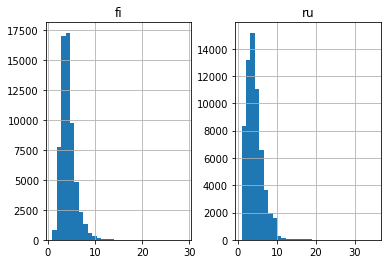

In [14]:
ru_l = [len(get_words(i)) for i in ru_sentences]
fi_l = [len(get_words(i)) for i in fi_sentences]
        
length_df = pd.DataFrame({'ru':ru_l, 'fi':fi_l}) 
length_df.hist(bins = 30) 
plt.show()

In [15]:
def tokenization(lines): 
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

### Prepare tokenizers

In [16]:
ru_tokenizer = tokenization(ru_sentences)
ru_vocab_size = len(ru_tokenizer.word_index) + 1
ru_length = max(ru_l)
ru_length

35

In [17]:
fi_tokenizer = tokenization(fi_sentences)
fi_vocab_size = len(fi_tokenizer.word_index) + 1
fi_length = max(fi_l)
fi_length

29

In [18]:
def encode_sequences(tokenizer, length, lines):          
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)      
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')        
    return seq

# FI - RU Model

In [19]:
train, test = train_test_split(processed_fi_ru, test_size=0.2, random_state=20)
train

array([['sanoiko tomi tekevänsä sen',
        'том сказал что собирается сделать это'],
       ['en ole nähnyt sinua aikoihin', 'я вас сто лет не видел'],
       ['meidän jääkaappimme on rikki', 'у нас холодильник сломался'],
       ...,
       ['tom tykkää ranskan opiskelusta',
        'тому нравится изучать французский'],
       ['tomi pystyi hädintuskin kävellä', 'том едва мог идти'],
       ['tom on päättänyt lopettaa tupakoinnin',
        'том решил бросить курить']], dtype='<U236')

### Prepare train dataset

In [20]:
trainX = encode_sequences(fi_tokenizer, fi_length, train[:, 0]) 
trainY = encode_sequences(ru_tokenizer, ru_length, train[:, 1]) 

In [21]:
print(train[:, 0][0])
print(trainX[0])

sanoiko tomi tekevänsä sen
[ 2915     4 17099    18     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]


In [22]:
print(train[:, 1][0])
print(trainY[0])

том сказал что собирается сделать это
[   3   63    7 1392   55    6    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


### Prepare test dataset

In [23]:
testX = encode_sequences(fi_tokenizer, fi_length, test[:, 0]) 
testY = encode_sequences(ru_tokenizer, ru_length, test[:, 1]) 

In [24]:
print(test[:, 0][0])
print(testX[0])

sinun täytyy korjata se
[ 14  40 440   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [25]:
print(test[:, 1][0])
print(testY[0])

вам нужно его починить
[ 25  74  26 569   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### Train NMT model

In [26]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):   
    model = Sequential()
    model.add(Embedding(in_vocab, n, input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(n))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(n, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
if os.path.exists(FILENAME):
    print('loading existing fi model')
    model = load_model(FILENAME)
else:
    model = build_model(fi_vocab_size, ru_vocab_size, fi_length, ru_length, 512)

    rms = optimizers.RMSprop(lr=0.001) 
    model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

loading existing fi model
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 39865 samples, validate on 9967 samples
Epoch 1/2
39865/39865 [==============================] - 1198s 30ms/step - loss: 0.4522 - val_loss: 0.4639

Epoch 00001: val_loss improved from inf to 0.46386, saving model to model.fi_ru_11_oct_19_RC1
Epoch 2/2
39865/39865 [==============================] - 1190s 30ms/step - loss: 0.4199 - val_loss: 0.4647

Epoch 00002: val_loss did not improve from 0.46386


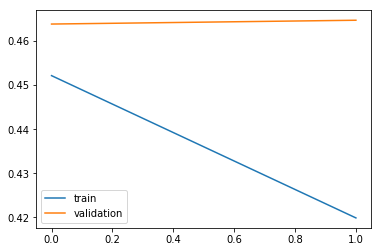

In [28]:
if NEED_TRAIN:
    checkpoint = ModelCheckpoint(FILENAME, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min')
    
    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=EPOCHS, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)
    
    print(history)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.show()

In [29]:
def get_word(n, tokenizer):  
    for word, index in tokenizer.word_index.items():                       
        if index == n: 
            return word 
    return None

In [30]:
def pre_tran(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence.lower()

In [31]:
def predict(sentence, source_tokenizer, source_len, target_tokenizer, mdl):
    sentence = pre_tran(sentence)
    source = encode_sequences(source_tokenizer, source_len, array([sentence]))
    p = mdl.predict_classes(source)[0]
    temp = []
    for j in range(len(p)):             
        t = get_word(p[j], target_tokenizer)
        if j > 0:                 
            if (t == get_word(p[j-1], target_tokenizer)) or (t == None):                       
                 temp.append('')
            else:
                 temp.append(t)
        else:       
            if(t == None):                             
                 temp.append('')
            else:
                 temp.append(t)
    return ' '.join(temp).strip()

In [32]:
def translate_fi_ru(sentence):
    return predict(sentence, fi_tokenizer, fi_length, ru_tokenizer, model)

In [42]:
translate_fi_ru('Ihanko oikeesti')

[  7 354   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


'что самом'

# RU - FI Model

In [34]:
ru_train_x = encode_sequences(ru_tokenizer, ru_length, train[:, 1]) 
ru_train_y = encode_sequences(fi_tokenizer, fi_length, train[:, 0]) 

In [35]:
ru_test_x = encode_sequences(ru_tokenizer, ru_length, test[:, 1]) 
ru_test_y = encode_sequences(fi_tokenizer, fi_length, test[:, 0]) 

In [36]:
if os.path.exists(FILENAME_RU):
    print('loading existing ru model')
    model_ru = load_model(FILENAME_RU)
else:
    model_ru = build_model(ru_vocab_size, fi_vocab_size, ru_length, fi_length, 512)

    rms = optimizers.RMSprop(lr=0.001) 
    model_ru.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

loading existing ru model


Train on 39865 samples, validate on 9967 samples
Epoch 1/2
39865/39865 [==============================] - 1136s 29ms/step - loss: 0.6080 - val_loss: 0.6164

Epoch 00001: val_loss improved from inf to 0.61636, saving model to model.ru_fi_28_oct
Epoch 2/2
39865/39865 [==============================] - 1139s 29ms/step - loss: 0.5665 - val_loss: 0.6138

Epoch 00002: val_loss improved from 0.61636 to 0.61375, saving model to model.ru_fi_28_oct


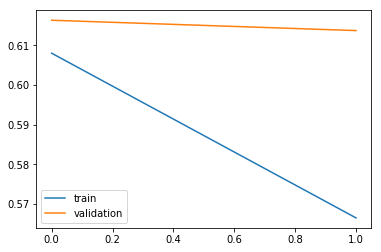

In [37]:
if NEED_TRAIN_RU:
    checkpoint_ru = ModelCheckpoint(FILENAME_RU, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min')
    
    history = model_ru.fit(ru_train_x, ru_train_y.reshape(ru_train_y.shape[0], ru_train_y.shape[1], 1), 
                    epochs=EPOCHS, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint_ru], verbose=1)
    
    print(history)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.show()

In [38]:
def translate_ru_fi(sentence):
    return predict(sentence, ru_tokenizer, ru_length, fi_tokenizer, model_ru)

In [39]:
translate_ru_fi('Думаю, Том тебя боится')

[135   8   2   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


'luulen että tom'

In [40]:
translate_ru_fi('Давай не будем тратить время на споры')

[  26   35 5397    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


'älä voi palauttaa'

In [41]:
translate_ru_fi('привет')

[619   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


'ala'